# Word-level GMM Error Detector

In [1]:
import sklearn.mixture
import numpy as np
import torch
import sys
sys.path.insert(0, "../")
import pprint
pp = pprint.PrettyPrinter()

from scipy.stats import mannwhitneyu

import matplotlib.pyplot as plt
%matplotlib inline

from utils import timed_func

In [2]:
# Load BEA sentences to train GMM
@timed_func
def parse_grammar_dataset():
    m2_path = "../data/BEA14/WI_LOCNESS/wi+locness/m2/A.train.gold.bea19.m2"
    with open(m2_path, "r") as f:
        raw_lines = f.readlines()

    data = []
    curr_item = {}
    for line in raw_lines:
        if line.startswith("S "):
            if len(curr_item) > 0 and len(curr_item["errors"]) > 0:
                curr_item["corrected_sent"] = _correct_sentence(curr_item)
                data.append(curr_item)
            curr_item = {"sentence": line[2:].strip(), "errors": []}
        elif line.startswith("A "):
            items = line.split("|||")
            start_pos_str, end_pos_str = items[0][2:].split()
            start_pos, end_pos = int(start_pos_str), int(end_pos_str)
            error = {
                "start_pos": start_pos,  # These are in terms of word locs
                "end_pos": end_pos,
                "correct": items[2] 
            }
            curr_item["errors"].append(error)

    print("Collected {} sentences".format(len(data)))
    sentences = [item['sentence'] for item in data]
    return data, sentences 

def _correct_sentence(item):
    """
    E.g., sent is "My town is a medium size city ..."
    errors is [{'start_pos': 5, 'end_pos': 6, 'correct': '- sized'}]
    Assume errors are sorted by start_pos.
    """
    sent = item['sentence']
    L = [w for w in sent.split()]
    newline = []
    i = 0
    for err in item['errors']:
        if err['start_pos'] == -1:  # This sentence is correct
            return sent
        newline.extend(L[i:err['start_pos']])
        newline.append(err['correct'])
        i = err['end_pos']
    newline.extend(L[i:])
    return _remove_repeated_spaces(" ".join(newline))

def _remove_repeated_spaces(s):
    return " ".join(s.split())
    
gec_data, gec_sentences = parse_grammar_dataset()

Collected 10492 sentences
parse_grammar_dataset done in 0.21 seconds.


In [3]:
gec_data[0]

{'sentence': 'My town is a medium size city with eighty thousand inhabitants .',
 'errors': [{'start_pos': 5, 'end_pos': 6, 'correct': '- sized'}],
 'corrected_sent': 'My town is a medium - sized city with eighty thousand inhabitants .'}

In [4]:
gec_samples = np.random.choice(gec_data, 1000)
gec_correct_sentences_train = [item['corrected_sent'] for item in gec_samples[:500]]
gec_correct_sentences_train[:10]

['This fact gives the government the opportunity to manage the traffic on the roads in cities or towns .',
 'The city was deserted that night , as Michael and I wandered through the narrow streets .',
 'Public transport is always crowded , so it is not comfortable to travel on .',
 'The government can improve public transport by making a great investment like changing the old vehicles for new and increasing the number of buses , trains and building more bus stops and trains stations . This kind of action will help a lot to improve the quality of public transport for the population and will make the life of the people easier .',
 "Nowadays , Easter is associated more with spring 's arrival than with religious rituals .",
 'I started my hobby when I was a child .',
 'Thank you',
 'The Great Wall is located to the north of Beijing .',
 'I believe both are useful .',
 'Secondly , owning a car is not a normal thing for most developing or undeveloped countries .']

## Word-level encoder

In [5]:
from transformers import AutoTokenizer, AutoModel
model_name = 'roberta-base'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

In [6]:
#sent = "An apple a day keeps the doctors away"
sent = "An idealistic opportunity does n't always lead to success."
tokens = tokenizer.tokenize(sent)
tokens

['An',
 'Ġideal',
 'istic',
 'Ġopportunity',
 'Ġdoes',
 'Ġn',
 "'t",
 'Ġalways',
 'Ġlead',
 'Ġto',
 'Ġsuccess',
 '.']

In [37]:
class SentEncoder:
    def __init__(self, model_name='roberta-base'):
        self.model_name = model_name
        self.auto_tokenizer = AutoTokenizer.from_pretrained(model_name)
        self.auto_model = AutoModel.from_pretrained(model_name)
        
    def _is_word_start(self, token, i):
        if i == 0:  # For convenience of future steps
            return False
        if self.model_name.startswith('roberta') or self.model_name == 'gpt2':
            return token.startswith("\u0120")
        elif self.model_name in ['bert-base-cased', 'bert-base-multilingual-cased']:
            return not token.startswith("##")
        else:
            raise NotImplementedError(f"model_name {model_name} is not supported")
            
    def _find_word_tokens(self, sent, tokens):
        if self.model_name.startswith('roberta') or self.model_name == 'gpt2':
            return sent.split()
        elif self.model_name in ['bert-base-cased', 'bert-base-multilingual-cased']:
            res, buf = [], []
            for i, token in enumerate(tokens):
                if token.startswith("##"):
                    buf.append(token[2:])
                else:
                    if i > 0:
                        res.append("".join(buf))
                    buf = [token]
            res.append(buf)
            return res
        else:
            raise NotImplementedError(f"model_name {model_name} is not supported")
        
    def encode_vecs_per_word(self, sent, add_special_tokens=False):
        """
        Input: sent (str)
        Output:
            tokens: list (n_words) of str
            all_hids: torch.tensor (n_words, n_layers, D)
        This method is suitable for Transformers without adding special tokens
        """
        tokens = self.auto_tokenizer.tokenize(sent)
        start_of_word_positions = \
            [i for i in range(len(tokens)) if self._is_word_start(tokens[i], i)]
        
        if add_special_tokens:  # i.e., RoBERTa
            sowp_list = [0] + start_of_word_positions
            start_of_word_positions = np.array(sowp_list) + 1
        else:
            start_of_word_positions = np.array(start_of_word_positions)
        word_tokens = self._find_word_tokens(sent, tokens)
        
        ids = torch.tensor(self.auto_tokenizer.encode(sent)).unsqueeze(0)
        final, last, hids = self.auto_model(ids, output_hidden_states=True)
        
        all_hids = []
        for layer in range(len(hids)):
            layer_hids = []
            i = 0
            for pos in start_of_word_positions:
                vecs = torch.mean(hids[layer][0:1, i:pos, :], dim=1)
                layer_hids.append(vecs)
                i = pos
            vecs = torch.mean(hids[layer][0:1, i:, :], dim=1)
            layer_hids.append(vecs)
            lh = torch.cat(layer_hids, dim=0).unsqueeze(0)  # (1, |S|_w, D)
            all_hids.append(lh)
        all_hids = torch.cat(all_hids, dim=0).permute([1, 0, 2])
        
        assert len(word_tokens) == len(all_hids), \
            "wt_len {} != transformer token len {}. word_tokens: {}".format(
            len(word_tokens), len(all_hids), word_tokens
        )
        return word_tokens, all_hids
    
    def contextual_token_vecs(self, sentences):
        """Returns: (similar shapes as src.sent_encoder.SentEncoder)
        ret_tokens: List[List[tokens]] one list for each sentence.
        ret_hids: List (len n. sentences) [np.array(n_words, 13, D=768)]
        """
        ret_tokens, ret_hids = [], []
        for sent in sentences:
            tokens, hids = self.encode_vecs_per_word(sent)
            ret_tokens.append(tokens)
            ret_hids.append(hids.detach().cpu().numpy())
        return ret_tokens, ret_hids

## Word-level grammar errors

Look at the locations where scores are the most extraordinary
(Let me do a token-level correlation)  
E.g.: One sentence has 5 tokens with grammar errors: at pos 1,2,3,5,4  
(1) The top 5 positions ranked by GMM surprisal scores, are 1,2,3,5,6  
Then the "token-level detection" accuracy would be 80%.   
(2) Is there a "threshold" for the GMM surprisal scores?

In [38]:
#enc = SentEncoder('roberta-base')
#enc = SentEncoder('gpt2')
enc = SentEncoder('bert-base-cased')
#enc = SentEncoder('bert-base-multilingual-cased')

In [39]:
#test_sent = "My town is a medium size city with eighty thousand inhabitants .\n"
test_sent = "An idealistic opportunity does n't work."
raw_tokens, vecs = enc.encode_vecs_per_word(test_sent)
print(len(raw_tokens), raw_tokens)
vecs.shape

9 ['An', 'idealistic', 'opportunity', 'does', 'n', "'", 't', 'work', ['.']]


torch.Size([9, 13, 768])

In [10]:
vecs.min(), vecs.max()

(tensor(-15.0468, grad_fn=<MinBackward1>),
 tensor(26.8665, grad_fn=<MaxBackward1>))

In [11]:
_, all_vecs = enc.contextual_token_vecs(gec_correct_sentences_train)

In [12]:
all_lens = [len(item) for item in all_vecs]
np.min(all_lens), np.max(all_lens)

(1, 133)

In [13]:
all_vecs[0].shape

(19, 13, 768)

In [16]:
#[np.min(vec) for vec in all_vecs]

In [17]:
class AnomalyModel:
    """Model that uses GMM on embeddings generated by BERT for finding syntactic
    or semantic anomalies.
    """

    def __init__(self, train_sentences, encoder_model='roberta-base'):
        self.enc = SentEncoder(encoder_model)
        self.gmms = []

        _, all_vecs = self.enc.contextual_token_vecs(train_sentences)
        for layer in range(13):
            sent_vecs = np.vstack([vs[:,layer,:] for vs in all_vecs])
            gmm = sklearn.mixture.GaussianMixture()
            gmm.fit(sent_vecs)
            self.gmms.append(gmm)


    def gmm_score(self, sentences):
        """Returns (all_tokens, all_scores), where
        all_tokens is List[List[token]]
        all_scores is List[np.array(num layers, |S|)]
        """

        all_tokens, all_vecs = self.enc.contextual_token_vecs(sentences)
        all_scores = []

        for sent_ix in range(len(sentences)):
            tokens = all_tokens[sent_ix]
            vecs = all_vecs[sent_ix]
            assert len(tokens) == vecs.shape[0]

            layer_scores = []
            for layer in range(13):
                scores = self.gmms[layer].score_samples(vecs[:, layer, :])
                layer_scores.append(scores)

            all_scores.append(np.array(layer_scores))
        return all_tokens, all_scores

In [18]:
anomaly_model = AnomalyModel(gec_correct_sentences_train)

In [19]:
test_samples = gec_samples[500:510]
test_sentences = [item['sentence'] for item in test_samples]
all_tokens, gmm_scores = anomaly_model.gmm_score(test_sentences)

In [20]:
def all_layer_scores(sample):
    sent = sample['sentence']
    pp.pprint(sample)
    tokens, all_layer = anomaly_model.gmm_score([sent])
    tokens = tokens[0]
    all_layer = all_layer[0]
    plt.figure(figsize=(8, 8))
    plt.imshow(all_layer, origin='lower')
    plt.xticks(range(len(tokens)), tokens, rotation='vertical')
    plt.yticks(range(12), range(12))
    plt.ylabel('Layer')
    plt.show()

{'corrected_sent': 'You have asked for a waiter in your cafe .',
 'errors': [{'correct': 'for', 'end_pos': 4, 'start_pos': 3},
            {'correct': 'waiter', 'end_pos': 6, 'start_pos': 5}],
 'sentence': 'You have asked about a server in your cafe .'}


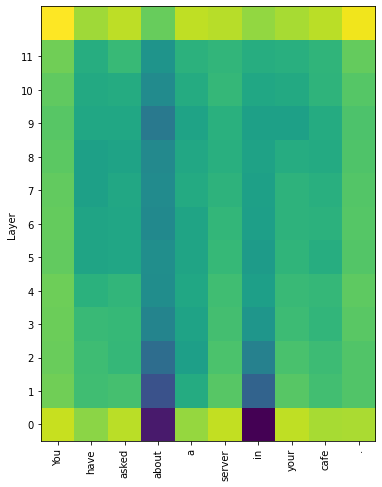

In [21]:
all_layer_scores(test_samples[0])

In [22]:
@timed_func
def verify_lengths(samples):
    """
    Note: This works for RoBERTa and GPT2. BERT splits e.g., n't into 3 tokens. So we
    should rely on the len(all_tokens[i]) given by the SentEncoder.
    """
    test_sentences = [item['sentence'] for item in samples]
    all_tokens, gmm_scores = anomaly_model.gmm_score(test_sentences)
    # Verify if the token lengths match sample sentence lengths

    equal = 0
    for i, sample in enumerate(samples):
        st_word_len = len(all_tokens[i])  # Given by transformers
        tr_word_len = len(test_sentences[i].split())  # Input sentence
        if tr_word_len == st_word_len:
            equal += 1
    print("Among {} samples, {} ({:.2f}%) have matched lens from two methods.".format(
        len(samples), equal, equal / len(samples) * 100
    ))
    
verify_lengths(gec_samples)

Among 1000 samples, 1000 (100.00%) have matched lens from two methods.
verify_lengths done in 102.41 seconds.


In [26]:
@timed_func
def true_false_bin(samples):
    test_sentences = [item['sentence'] for item in samples]
    all_tokens, gmm_scores = anomaly_model.gmm_score(test_sentences)
    
    for layer in range(13):
        print ("=====Layer {}=====".format(layer))
        scores_correct, scores_typo = [], []
        for i, sample in enumerate(samples):
            if sample['errors'][0]['start_pos'] == -1:  # This sentence is correct
                scores_correct += gmm_scores[i][layer].tolist()
            else:
                # These T/F sentinels mark the errors of this sentence
                st_word_len = len(all_tokens[i])
                
                sentinels = np.ones(st_word_len)
                for gerr in sample['errors']:
                    sentinels[gerr['start_pos']: gerr['end_pos']] = 0  # broadcast
                
                for j in range(len(sentinels)):
                    if sentinels[j]:
                        scores_correct.append(gmm_scores[i][layer,j])
                    else:
                        scores_typo.append(gmm_scores[i][layer,j])
        print ("Correct words (total {}): avg score: {:.2f}, std {:.2f}".format(
            len(scores_correct),
            np.mean(scores_correct), np.std(scores_correct)
        ))
        print ("Incorrect words (total {}): avg score: {:.2f}, std {:.2f}".format(
            len(scores_typo),
            np.mean(scores_typo), np.std(scores_typo)
        ))
        stat, p = mannwhitneyu(scores_correct, scores_typo)
        # https://machinelearningmastery.com/statistical-hypothesis-tests-in-python-cheat-sheet/
        # Non-normal for both arrays
        u_test_res = "Same" if p>0.05 else "Different"
        print ("Mann Whitney U test: p={}. {} distributions.".format(p, u_test_res))
        
true_false_bin(gec_samples[500:])

=====Layer 0=====
Correct words (total 7617): avg score: 234.68, std 625.88
Incorrect words (total 1402): avg score: 10.98, std 732.24
Mann Whitney U test: p=2.427541425815511e-26. Different distributions.
=====Layer 1=====
Correct words (total 7617): avg score: -126.04, std 357.21
Incorrect words (total 1402): avg score: -252.05, std 393.95
Mann Whitney U test: p=3.214187967009049e-33. Different distributions.
=====Layer 2=====
Correct words (total 7617): avg score: -163.72, std 264.42
Incorrect words (total 1402): avg score: -254.97, std 265.19
Mann Whitney U test: p=4.902447826084232e-37. Different distributions.
=====Layer 3=====
Correct words (total 7617): avg score: -145.88, std 214.49
Incorrect words (total 1402): avg score: -231.61, std 197.12
Mann Whitney U test: p=5.1862277392489386e-52. Different distributions.
=====Layer 4=====
Correct words (total 7617): avg score: -144.94, std 206.44
Incorrect words (total 1402): avg score: -226.60, std 175.94
Mann Whitney U test: p=1.667

## Observations up till now:  
1. There are separations between the GMM scores for "correct words" and "incorrect words".  
2. Except for layer 12, the `p` values in general decrease as layers go up. This might indicate that higher layers are more surprised at grammar errors.  
3. The large std indicate that there might not be a clear-cut threshold, for us to say "when the surprisal score is beyond / below this threshold, this is grammar error".  

## Word-level grammar error detection
- Now that I have the surprisal score and the true labels. Evaluate on (1) the ROC curve, (2) report the ROC_AUC_score  
- This can be a baseline metric to contrast to residualization.

In [41]:
from sklearn.metrics import roc_auc_score

@timed_func
def ged_evaluation(anomaly_model, samples):
    test_sentences = [item['sentence'] for item in samples]
    all_tokens, gmm_scores = anomaly_model.gmm_score(test_sentences)
    
    for layer in range(13):
        pred_scores = []
        y_true = []
        for i, sample in enumerate(samples):
            st_word_len = len(all_tokens[i])
            
            if sample['errors'][0]['start_pos'] == -1:  # This sentence is ok
                y_true += [1] * st_word_len
            else:
                sentinels = np.ones(st_word_len)
                for gerr in sample['errors']:
                    sentinels[gerr['start_pos']: gerr['end_pos']] = 0  # broadcast
                y_true += sentinels.tolist()
            pred_scores += gmm_scores[i][layer].tolist()
                
        auroc = roc_auc_score(y_true, pred_scores)
        print ("Layer {} AUROC {:.4f}".format(layer, auroc))

In [44]:
for model_name in ['bert-base-multilingual-cased', 'bert-base-cased', 'roberta-base', 'gpt2']:
    print("\n ### Model: {} ###".format(model_name))
    anomaly_model = AnomalyModel(gec_correct_sentences_train, model_name)
    ged_evaluation(anomaly_model, gec_samples[500:])


 ### Model: bert-base-multilingual-cased ###
Layer 0 AUROC 0.5425
Layer 1 AUROC 0.5429
Layer 2 AUROC 0.5513
Layer 3 AUROC 0.5553
Layer 4 AUROC 0.5597
Layer 5 AUROC 0.5610
Layer 6 AUROC 0.5610
Layer 7 AUROC 0.5762
Layer 8 AUROC 0.5800
Layer 9 AUROC 0.5819
Layer 10 AUROC 0.5802
Layer 11 AUROC 0.5774
Layer 12 AUROC 0.5357
ged_evaluation done in 78.12 seconds.

 ### Model: bert-base-cased ###
Layer 0 AUROC 0.5360
Layer 1 AUROC 0.5373
Layer 2 AUROC 0.5471
Layer 3 AUROC 0.5561
Layer 4 AUROC 0.5597
Layer 5 AUROC 0.5649
Layer 6 AUROC 0.5685
Layer 7 AUROC 0.5724
Layer 8 AUROC 0.5729
Layer 9 AUROC 0.5714
Layer 10 AUROC 0.5708
Layer 11 AUROC 0.5725
Layer 12 AUROC 0.5217
ged_evaluation done in 52.33 seconds.

 ### Model: roberta-base ###
Layer 0 AUROC 0.5419
Layer 1 AUROC 0.5532
Layer 2 AUROC 0.5643
Layer 3 AUROC 0.5610
Layer 4 AUROC 0.5593
Layer 5 AUROC 0.5689
Layer 6 AUROC 0.5699
Layer 7 AUROC 0.5767
Layer 8 AUROC 0.5645
Layer 9 AUROC 0.5718
Layer 10 AUROC 0.5979
Layer 11 AUROC 0.6002
Layer 12 

Some weights of GPT2Model were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.attn.masked_bias', 'h.1.attn.masked_bias', 'h.2.attn.masked_bias', 'h.3.attn.masked_bias', 'h.4.attn.masked_bias', 'h.5.attn.masked_bias', 'h.6.attn.masked_bias', 'h.7.attn.masked_bias', 'h.8.attn.masked_bias', 'h.9.attn.masked_bias', 'h.10.attn.masked_bias', 'h.11.attn.masked_bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Layer 0 AUROC 0.6038
Layer 1 AUROC 0.5954
Layer 2 AUROC 0.5968
Layer 3 AUROC 0.5974
Layer 4 AUROC 0.5952
Layer 5 AUROC 0.5895
Layer 6 AUROC 0.5921
Layer 7 AUROC 0.5872
Layer 8 AUROC 0.5893
Layer 9 AUROC 0.5842
Layer 10 AUROC 0.5735
Layer 11 AUROC 0.5582
Layer 12 AUROC 0.5818
ged_evaluation done in 54.31 seconds.


## Word-level grammar error detection with residualization

This is not compatible with the GMM setting, because:  
Let representations be $X$, frequency be $c$, target (grammar correctness) be $Y$, then the GMM implicitly learns $P_\theta(Y|X;c)$. Note that is is **not** possible to get $P_\theta(Y|X;c=Const)$ in this unsupervised setting. Let's proceed without the residualization idea.  

One potential idea, training a separate $q(Y|X;c)$ with an MLP, then taking $q(Y|X;c=Const)$ as the real $q(Y|X)$, is not relevant to GMM, and is not unsupervised.  